In [18]:
#基于清洗过后的数据进行价格预测
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#读取数据
data = pd.read_csv('laptop_data.csv')
print(data.head())

  Company      Product   TypeName  Inches   Ram  OpSys  Weight  Price_euros  \
0   Apple  MacBook Pro  Ultrabook    13.3   8GB  macOS    1.37      1339.69   
1   Apple  Macbook Air  Ultrabook    13.3   8GB  macOS    1.34       898.94   
2      HP       250 G6   Notebook    15.6   8GB  No OS    1.86       575.00   
3   Apple  MacBook Pro  Ultrabook    15.4  16GB  macOS    1.83      2537.45   
4   Apple  MacBook Pro  Ultrabook    13.3   8GB  macOS    1.37      1803.60   

         分辨率                    Screen CPU_Brand  CPU_Rank  GPU_Rank  \
0  2560x1600  IPS Panel Retina Display     Intel       3.0       2.0   
1   1440x900                       NaN     Intel       3.0       1.0   
2  1920x1080                   Full HD     Intel       3.0       2.0   
3  2880x1800  IPS Panel Retina Display     Intel       1.0       4.0   
4  2560x1600  IPS Panel Retina Display     Intel       3.0       2.0   

  Memory1_Size   Memory1_Type Memory2_Size Memory2_Type  
0        128GB            SSD     

In [3]:
#依照回归分析内容，删除部分变量
df =  data.drop(columns=['Product','Screen']) 

In [4]:
#为便于进行训练和预测，对剩余非数字变量进行处理

def replace_cpy(cpy):
    if cpy in ['HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Toshiba']:
        return 'A类'
    elif cpy in ['Apple', 'MSI', 'Microsoft', 'Huawei', 'Xiaomi', 'Razer', 'Samsung', 'Google', 'LG']:
        return 'B类'
    elif cpy in ['Chuwi', 'Vero', 'Mediacom', 'Fujitsu']:
        return 'C类'

df['Company'] = df['Company'].apply(replace_cpy)

print(df[['Company']])

     Company
0         B类
1         B类
2         A类
3         B类
4         B类
...      ...
1298      A类
1299      A类
1300      A类
1301      A类
1302      A类

[1303 rows x 1 columns]


In [5]:
#操作系统归类
def replace_os(os):
    if os in ['macOS', 'Mac OS X']:
        return 'Mac OS'
    elif os in ['Windows 10', 'Windows 10 S', 'Windows 7']:
        return 'Windows'
    elif os == 'No OS':
        return 'No OS'
    else:
        return 'Other OS'

df['OpSys'] = df['OpSys'].apply(replace_os)

print(df[['OpSys']])

        OpSys
0      Mac OS
1      Mac OS
2       No OS
3      Mac OS
4      Mac OS
...       ...
1298  Windows
1299  Windows
1300  Windows
1301  Windows
1302  Windows

[1303 rows x 1 columns]


In [6]:
# 定义分辨率分类
resolution_mapping = {
    '3840x2160': 1,
    '3200x1800': 2,
    '2880x1800': 2,
    '2736x1824': 2,
    '2560x1600': 3,
    '2304x1440': 3,
    '2256x1504': 3,
    '2160x1440': 3,
    '2560x1440': 3,
    '2400x1600': 3,
    '1920x1080': 4,
    '1920x1200': 4,
    '1440x900': 5,
    '1366x768': 5,
    '1600x900': 5
}

# 替换分辨率为对应的类别
df['分辨率'] = df['分辨率'].map(resolution_mapping)

# 查看结果
print(df[['分辨率']])

      分辨率
0       3
1       5
2       4
3       2
4       3
...   ...
1298    4
1299    2
1300    5
1301    5
1302    5

[1303 rows x 1 columns]


In [7]:
#更改为数值变量
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

In [8]:
df['Memory1_Size'] = df['Memory1_Size'].str.replace('GB', '')
df['Memory1_Size'] = df['Memory1_Size'].str.replace('1TB', '1024')
df['Memory1_Size'] = df['Memory1_Size'].str.replace('1.0TB', '1024')
df['Memory1_Size'] = df['Memory1_Size'].str.replace('2TB', '2048')

In [9]:
df['Memory1_Size'] = df['Memory1_Size'].astype(int)

In [10]:
df['Memory2_Size'] = df['Memory2_Size'].str.replace('GB', '')
df['Memory2_Size'] = df['Memory2_Size'].str.replace('1TB', '1024')
df['Memory2_Size'] = df['Memory2_Size'].str.replace('1.0TB', '1024')
df['Memory2_Size'] = df['Memory2_Size'].str.replace('2TB', '2048')
df['Memory2_Size'] = df['Memory2_Size'].fillna(0).astype(int)

In [11]:
#对非数值数据进行独热编码
df_set  = pd.get_dummies(df, columns=['Company', 'TypeName', 'OpSys', 'CPU_Brand', 'Memory1_Type', 'Memory2_Type'])
print(df_set)

      Inches  Ram  Weight  Price_euros  分辨率  CPU_Rank  GPU_Rank  Memory1_Size  \
0       13.3    8    1.37      1339.69    3       3.0       2.0           128   
1       13.3    8    1.34       898.94    5       3.0       1.0           128   
2       15.6    8    1.86       575.00    4       3.0       2.0           256   
3       15.4   16    1.83      2537.45    2       1.0       4.0           512   
4       13.3    8    1.37      1803.60    3       3.0       2.0           256   
...      ...  ...     ...          ...  ...       ...       ...           ...   
1298    14.0    4    1.80       638.00    4       4.0       2.0           128   
1299    13.3   16    1.30      1499.00    2       4.0       2.0           512   
1300    14.0    2    1.50       229.00    5       1.0       2.0            64   
1301    15.6    6    2.19       764.00    5       4.0       3.0          1024   
1302    15.6    4    2.20       369.00    5       1.0       2.0           500   

      Memory2_Size  Company

In [12]:
df_set.to_csv('预测.csv', index=False)

In [13]:
#按80%，20%的比例划分训练集和测试集
X = df_set.drop('Price_euros', axis=1)
y = df_set['Price_euros']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

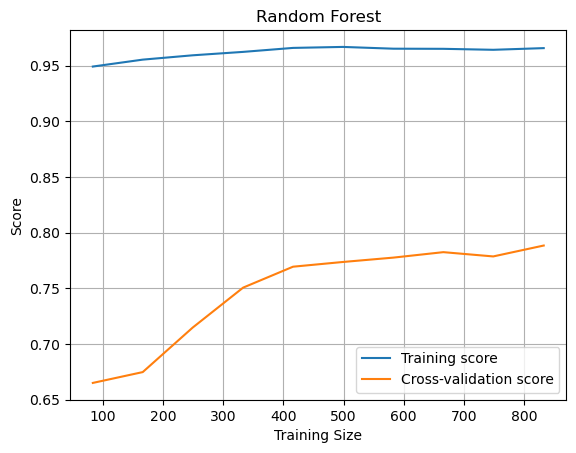

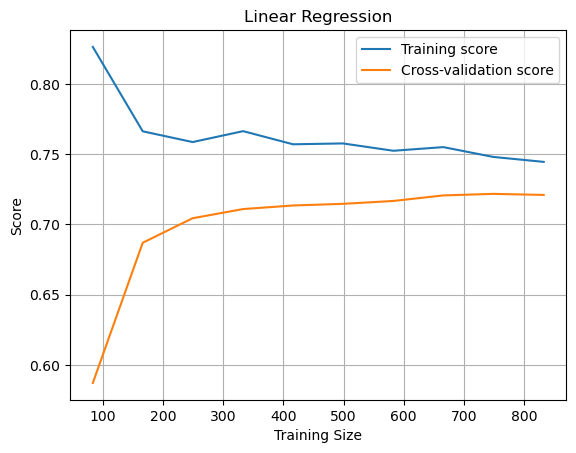

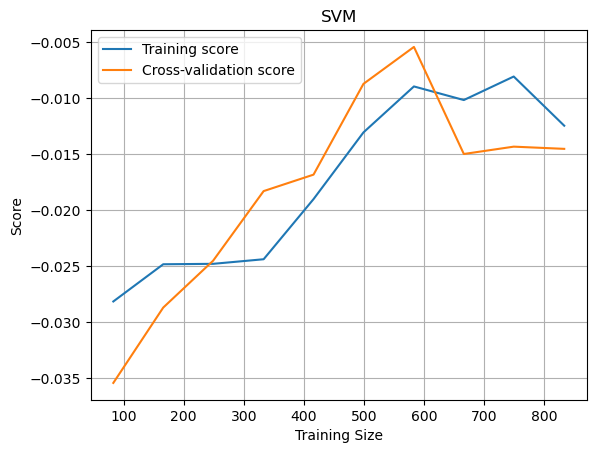

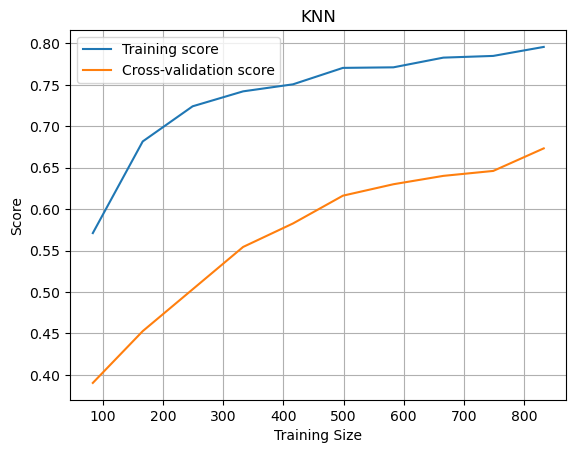

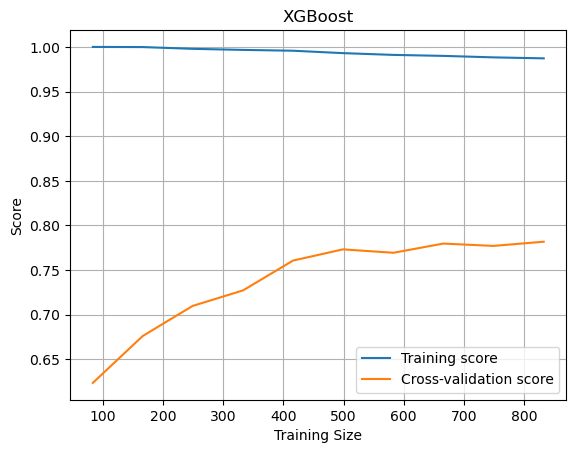

Random Forest Mean Squared Error: 95582.96, R²: 0.81
Linear Regression Mean Squared Error: 108427.31, R²: 0.78
SVM Mean Squared Error: 507953.20, R²: -0.03
KNN Mean Squared Error: 113855.91, R²: 0.77
XGBoost Mean Squared Error: 84291.67, R²: 0.83


In [17]:
#初步预测
# 定义模型
models = {
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'SVM': SVR(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor()
}

# 绘制学习曲线
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

# 训练模型并绘制学习曲线
for name, model in models.items():
    plot_learning_curve(model, X_train, y_train, title=name)

# 评估模型性能
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f'{name} Mean Squared Error: {mse:.2f}, R²: {r2:.2f}')

In [19]:
#调参
# 定义模型和超参数网格
models_params = {
    'Random Forest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'KNN': (KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance']
    }),
    'XGBoost': (XGBRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    })
}

# 网格搜索调参
best_models = {}
for name, (model, params) in models_params.items():
    grid_search = GridSearchCV(model, params, scoring='r2', cv=5)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    print(f'{name} Best Parameters: {grid_search.best_params_}, Best R²: {grid_search.best_score_:.2f}')

# 使用最佳参数训练模型并进行预测
for name, model in best_models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    print(f'{name} Test R²: {r2:.2f}')

Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}, Best R²: 0.80
KNN Best Parameters: {'n_neighbors': 3, 'weights': 'uniform'}, Best R²: 0.69
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, Best R²: 0.81
Random Forest Test R²: 0.81
KNN Test R²: 0.76
XGBoost Test R²: 0.85
